In [1]:
import pandas as pd
from dataretrieval import nwis 
from matplotlib import pyplot as plt 
import datetime


def get_usgs_data():

  # Retrieve the data
  siteNumber    = ["03293000","03293500","03292500","03292555","03293530","03293510"]
  parameterCode = "00060"
  startDate     = "2005-01-01"
  endDate       = "2021-12-31"
  
  (dailyStreamflow, info) = nwis.get_dv(sites=siteNumber,
                                        parameterCd=parameterCode,
                                        start=startDate,
                                        end = endDate
                                        )
  # Reshape the DataFrame
  dischargeDF = dailyStreamflow.reset_index().pivot(index='datetime',columns='site_no')[parameterCode + "_Mean"]
  # Remove Time Zone info from the Discharge DF
  dischargeDF.index = dischargeDF.reset_index()['datetime'].dt.tz_localize(None)
  return dischargeDF

def get_msdFlow():


  msd_path = "./data/raw/MSD_Flow_2019_2021.csv"
  
  msd_flowDF = pd.read_csv(msd_path,index_col='Date',parse_dates=True)
  
  return (msd_flowDF)

In [2]:

dischargeDF = get_usgs_data()
Qmsd = get_msdFlow()
Qmsd_norm = Qmsd/Qmsd.mean()

Q_year = dischargeDF.resample('Y', label = "left").mean()[dischargeDF.resample('Y').count() >= 360]
cum_msd = Qmsd_norm.dropna().cumsum()

discharge_cols = dischargeDF.columns 
matched_discharged = cum_msd.join(dischargeDF)[discharge_cols]
cum_discharge = matched_discharged.dropna().cumsum().sum(axis = 1)

#  Discharge Time series

In [ ]:
#%%  Discharge Time series
fig, axs = plt.subplots(5,1, sharex = True, figsize = (12,8) ) 
i = 0
for ax, (name, dataD), (name2, dataY) in zip(axs, dischargeDF.items(), Q_year.items()):
    ax2 = ax.twinx()
    ax.plot(dataD, color = "grey", label = "Daily")
    ax2.plot(dataY.index, dataY, color = "k", label = "Annual", marker = "o")
    
    ax.set_ylabel("Daily Q")
    ax2.set_ylabel("Annual mean")
    ax.set_title(name)
    i += 1
    if i == 2:
        ax.legend(loc = "upper left")
        ax2.legend(loc = "center left")

plt.subplots_adjust(hspace = 0.3)

fig.suptitle("Stream Flow", fontsize = 20)
# plt.savefig("01_USGS_flow.png")

# Double Mass Curves

In [3]:
title_mapper = {"MFWQTC(MGD)" : "A) Morris Forman", 
                "DRGWQTC(MGD)": "B) Derek R.Guthrie",
                "CCWQTC(MGD)" : "C) Cedar Creek",
                "FFWQTP(MGD)" : "D) Floyds Fork",
                "HCWQTP(MGD)" : "E) Hite Creek"
}
colors           = ["#999999","#E69F00"]
ticklabel_size   = 8
annot_labl_size  = 9
labl_size      = 9
title_size       = 11
legend_lbl_size  = 9
wspace = 0.07

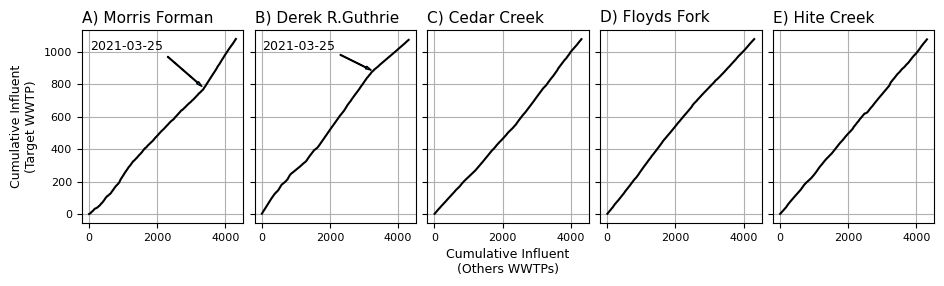

In [5]:
#%%  This for the paper
fig, axs = plt.subplots(1,5, figsize = (11,2.5), sharey = True ) 
i = 0
tipping_date = "2021-03-25"
for ax, (name, cumdata) in zip(axs, cum_msd.items()):
    others_cum_data = cum_msd.drop(name, axis = 1).sum(axis = 1)
    ax.plot(others_cum_data, cumdata, color = "k")
    
    if i == 0:
        x,y = others_cum_data[tipping_date],cumdata[tipping_date]
        # ax.scatter(x,y, color = "r")
        ax.annotate(tipping_date, xy = (x,y), xytext = (0.05,0.9), textcoords = "axes fraction", fontsize = labl_size, arrowprops = {"width":.5, "headwidth":2, "shrink":0.05, "headlength": 4 })
        ax.set_ylabel("Cumulative Influent\n(Target WWTP)", fontsize = labl_size)
    if i == 1:
        x,y = others_cum_data[tipping_date],cumdata[tipping_date]
        # ax.scatter(x,y, color = "r")
        ax.annotate(tipping_date, xy = (x,y), xytext = (0.05,0.9), textcoords = "axes fraction",fontsize = labl_size, arrowprops = {"width":.5, "headwidth":2, "shrink":0.05, "headlength": 4 })

    i += 1
    
    
    ax.set_title(title_mapper[name], loc = "left", fontsize = title_size)
    ax.grid(True)
    ax.tick_params(labelsize = ticklabel_size)
axs[2].set_xlabel("Cumulative Influent\n(Others WWTPs)", fontsize = labl_size)
plt.subplots_adjust(wspace = wspace)
# fig.suptitle("Double-Mass curve", fontsize = 20)
plt.savefig("./Results/Figs/Fig_SI_Double_mass.png", bbox_inches='tight', dpi = 300)

# Double mass curves using discharge

In [ ]:
#%% Double mass curve with discharge 
fig, axs = plt.subplots(1,5, figsize = (15,3) ) 
i = 0
tipping_dates = ["2021-02-25","2019-08-01"]
for ax, (name, cumdata) in zip(axs, cum_msd.items()):
    
    ax.plot(cum_discharge, cumdata, color = "k")

    
    # ax.scatter(x,y, color = "r")
    for tipping_date in tipping_dates:
        x,y = cum_discharge[tipping_date],cumdata[tipping_date]
        ax.annotate(tipping_date, 
                    xy = (x,y), 
                    xytext = (-5,20),
                    ha = "right" ,
                    textcoords = "offset points", 
                    fontsize = 7,
                    arrowprops = {"width":.5, "headwidth":2, "shrink":0.1, "headlength": 4 }
                    )


    i += 1
    ax.set_ylabel(name)
    ax.set_xlabel("Stream Flow")
    ax.set_title(name)
    ax.grid(True)

plt.subplots_adjust(hspace = 0.3, wspace = 0.45, top = 0.8, bottom = 0.2)
fig.suptitle("Double-Mass curve", fontsize = 20)


# Scatter Plots

In [ ]:
#%% Scatter Plots

gages = ["03293510", "03293000"]
plants = ["MFWQTC(MGD)", "DRGWQTC(MGD)"]

alldata = matched_discharged.join(Qmsd)

fig, axs = plt.subplots(1,2)

axs

for i, (gage, plant) in enumerate(zip(gages, plants)):
    ax1 = axs[i]

    ax1.scatter(alldata.loc[:"2021-03-25",gage], 
                alldata.loc[:"2021-03-25",plant], 
                label = "01/2019 - 03/2021",
                alpha = 0.35,
                s = 8
                )
    ax1.scatter(alldata.loc["2021-03-25":,gage], 

                alldata.loc["2021-03-25":,plant], 
                color = "tab:red" ,
                label = "03/2021 - 12/2021",
                alpha = 0.35,
                s = 8
                )

    ax1.set_ylim(8,500)

    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_xlabel(gage)
    ax1.set_ylabel(plant)
ax1.legend()
# plt.savefig("05_Scatter.png")